<a href="https://colab.research.google.com/github/rahulkumar-datascientist/Detecting-Silent-Cardiac-Atrial-fibrillation-from-PPG-and-single-lead-ECG-Data-using-CNN-LSTM/blob/master/4.%20CNN_LSTM_models_PhysioNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Packages

In [ ]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import os, os.path
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

import zipfile
import re
import pickle
import keras
from sklearn.model_selection import train_test_split
from keras.layers import Bidirectional, LSTM, Activation, Dense, Dropout, BatchNormalization, InputLayer, Conv1D, MaxPooling1D, Flatten
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf



# Preparing the data according to the model Architecture

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Galenband Project

/content/drive/MyDrive/Colab Notebooks/Galenband Project


In [ ]:
# loading the saved dataframe
train_normalised                  = pd.read_pickle('Dataframes/Train_normalised.pkl')
train_normalised_aug              = pd.read_pickle('Dataframes/Train_normalised_aug.pkl')

test_normalised                   = pd.read_pickle('Dataframes/Test_normalised.pkl')

### Function to prepare train, test and validation data

In [ ]:
def prepare_data(train_set, test_set, test_prop = 0.3):

  # splitting the data into test and validation set
  val_set, test_set = train_test_split(test_set, test_size=test_prop, random_state=42, shuffle=True)
  
  test_set.reset_index(drop=True, inplace=True)
  val_set.reset_index(drop=True, inplace=True)

  # Splitting into input and output variables
  X_train = train_set.signals
  Y_train = train_set.output_label

  X_test = test_set.signals
  Y_test = test_set.output_label

  X_val = val_set.signals
  Y_val = val_set.output_label

  #####
  input_train   = np.zeros((len(X_train), 9000), dtype='float32')
  output_train = np.zeros(len(Y_train), dtype='float32')

  input_test   = np.zeros((len(X_test), 9000), dtype='float32')
  output_test = np.zeros(len(Y_test), dtype='float32')

  input_val   = np.zeros((len(X_val), 9000), dtype='float32')
  output_val = np.zeros(len(Y_val), dtype='float32')

  # modeling X input
  for index, value in enumerate(X_train):
    input_train[index] = value[0]


  for index, value in enumerate(X_test):
    input_test[index] = value[0]


  for index, value in enumerate(X_val):
    input_val[index] = value[0]

  
  # class 0 = Normal, class 1 = Afib
  # modeling Y output
  for index,value in enumerate(Y_train):
    if(value == 'N'):
      output_train[index] = 0
    else:
      output_train[index] = 1

  # modeling Y output
  for index,value in enumerate(Y_test):
    if(value == 'N'):
      output_test[index] = 0
    else:
      output_test[index] = 1

  # modeling Y output
  for index,value in enumerate(Y_val):
    if(value == 'N'):
      output_val[index] = 0
    else:
      output_val[index] = 1

  ## expanding the dimensions
  input_train = input_train.reshape(len(input_train), 9000, 1)
  output_train = output_train.reshape(len(output_train), 1)

  input_test = input_test.reshape(len(input_test), 9000, 1)
  output_test = output_test.reshape(len(output_test), 1)

  input_val = input_val.reshape(len(input_val), 9000, 1)
  output_val = output_val.reshape(len(output_val), 1)

  ## return the data
  return (input_train, output_train, input_test, output_test, input_val, output_val)



## 1.1 Model using Normal data

In [ ]:
input_train, output_train, input_test, output_test, input_val, output_val = prepare_data(train_normalised, test_normalised, 0.3)

In [ ]:
print("input train shape:\t ", input_train.shape)
print("output train shape:\t ", output_train.shape)

print("\ninput test shape:\t ", input_test.shape)
print("output test shape:\t ", output_test.shape)

print("\ninput val shape:\t ", input_val.shape)
print("output val shape:\t ", output_val.shape)

input train shape:	  (3975, 9000, 1)
output train shape:	  (3975, 1)

input test shape:	  (504, 9000, 1)
output test shape:	  (504, 1)

input val shape:	  (1176, 9000, 1)
output val shape:	  (1176, 1)


In [ ]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(output_train.flatten()), output_train.flatten())

class_weight_dict = dict(enumerate(class_weights))

class_weight_dict

class_weight_dict_1 = {0: 1.0, 1: 6.0}

class_weight_dict_1

{0: 1.0, 1: 6.0}

In [ ]:
# Defining parameter values
epochs          = 300
batch_size      = 32

In [ ]:
model_1 = Sequential()

# 64, 64, 32, 16, 8, 32

input_shape = (9000, 1)
model_1.add(InputLayer(input_shape=input_shape))

model_1.add(Conv1D(64, 10,padding='causal', activation="tanh"))
model_1.add(MaxPooling1D(4))

model_1.add(Conv1D(64, 10,padding='same', activation="tanh"))
model_1.add(MaxPooling1D(4))

model_1.add(LSTM(32,activation = "tanh", return_sequences = True))
model_1.add(LSTM(16, activation = "tanh", return_sequences = True))
model_1.add(LSTM(8, activation = "tanh"))

model_1.add(Dense(32, activation='tanh'))
model_1.add(BatchNormalization())
model_1.add(Dense(1, activation = 'sigmoid'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 9000, 64)          704       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2250, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2250, 64)          41024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 562, 64)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 562, 32)           12416     
_________________________________________________________________
lstm_1 (LSTM)                (None, 562, 16)           3136      
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 8

In [ ]:
# model training configuration 
model_1.compile(optimizer = tf.keras.optimizers.Adam(),
                                    loss      = keras.losses.BinaryCrossentropy(),
                                    metrics   = [keras.metrics.BinaryAccuracy()])

#SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Callback to reduce the learning rate when the validation loss has stopped improving
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 25, mode = 'min')

# Callback to stop training the model when the validation loss has stopped improving
# early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 40, mode = 'min')

# CHECKPOINT callback
filepath = "Training_models/PhysioNet 2017/Model 1/ECG.epoch_{epoch:02d}.TL_{loss:.4f}.VL_{val_loss:.4f}.TA_{binary_accuracy:.2f}.VA_{val_binary_accuracy:.2f}.hdf5"

# Save training model when there is an improvement in validation_accuracy from the previous checkpint
model_save = keras.callbacks.ModelCheckpoint(filepath, 
                                             monitor = 'val_binary_accuracy',
                                             save_best_only=True, 
                                             mode = 'max')




In [ ]:
# Fitting the model
model_1_his = model_1.fit(input_train, output_train,
                      batch_size = batch_size , epochs = epochs, 
                      validation_data = (input_val, output_val),
                      class_weight=class_weight_dict_1,
                      callbacks=[reduce_lr,model_save])

model_1.save('Training_models/PhysioNet 2017/Model 1/ECG_final_run.hdf5')

Epoch 1/300
125/125 [==============================] - 29s 84ms/step - loss: 1.1144 - binary_accuracy: 0.5940 - val_loss: 0.6519 - val_binary_accuracy: 0.8869
Epoch 2/300
125/125 [==============================] - 10s 77ms/step - loss: 1.0943 - binary_accuracy: 0.6483 - val_loss: 0.6184 - val_binary_accuracy: 0.7764
Epoch 3/300
125/125 [==============================] - 10s 77ms/step - loss: 1.0382 - binary_accuracy: 0.6843 - val_loss: 0.5394 - val_binary_accuracy: 0.8316
Epoch 4/300
125/125 [==============================] - 10s 77ms/step - loss: 0.9557 - binary_accuracy: 0.7150 - val_loss: 0.4119 - val_binary_accuracy: 0.8656
Epoch 5/300
125/125 [==============================] - 10s 77ms/step - loss: 0.8892 - binary_accuracy: 0.7467 - val_loss: 1.1279 - val_binary_accuracy: 0.3750
Epoch 6/300
125/125 [==============================] - 10s 77ms/step - loss: 0.8500 - binary_accuracy: 0.7713 - val_loss: 0.3193 - val_binary_accuracy: 0.8929
Epoch 7/300
125/125 [=========================

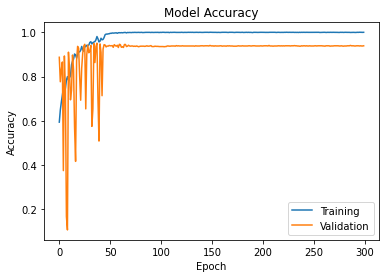

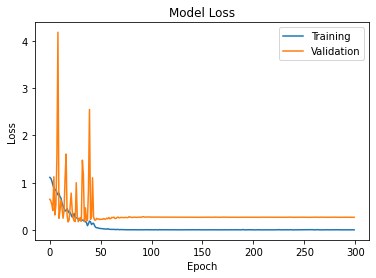

In [ ]:
# list all data in history
# print(model_history.history.keys())

model_history = model_1_his

# summarize history for accuracy
plt.plot(model_history.history['binary_accuracy'])
plt.plot(model_history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.ylim([0.60, 1.00])
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()

Model Evaluation

In [ ]:
model = keras.models.load_model('Training_models/PhysioNet 2017/Model 1/ECG_final_run.hdf5')
# model = model_1
test_scores = model.evaluate(input_test, output_test, verbose = 0)
print("Test loss:", test_scores[0])               # 0.1305         
print("Test accuracy:", test_scores[1])           # 0.9650


# # Load the Final model


# test_scores = model.evaluate(input_test, output_test, verbose = 0)
# print("Test loss:", test_scores[0])               # 0.1305         
# print("Test accuracy:", test_scores[1])           # 0.9650

Test loss: 0.30817005038261414
Test accuracy: 0.9365079402923584


In [ ]:
yhat = (model.predict(input_test) > 0.5).astype("int32")

conf_matrix = confusion_matrix(output_test,yhat)

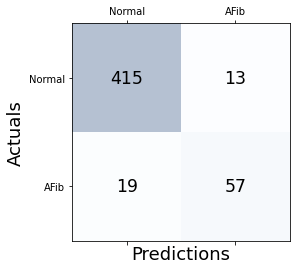

In [ ]:
# Print the confusion matrix using Matplotlib
labels = ['Normal', 'AFib']

fig, ax = plt.subplots()
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.show()

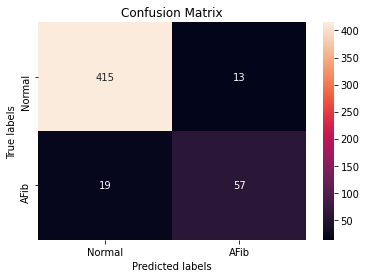

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Normal', 'AFib']); ax.yaxis.set_ticklabels(['Normal', 'AFib']);


In [ ]:
accuracy = accuracy_score(output_test, yhat)
print('Accuracy:\t\t', round(accuracy,4))

# precision tp / (tp + fp)
precision = precision_score(output_test, yhat)
print('Precision:\t\t', round(precision,4))

# recall: tp / (tp + fn)
recall = recall_score(output_test, yhat)
print('Recall: \t\t', round(recall,4))

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(output_test, yhat)
print('F1 score:\t\t', round(f1,4))

Accuracy:		 0.9365
Precision:		 0.8143
Recall: 		 0.75
F1 score:		 0.7808


## 1.2 Model using Augmented data

In [ ]:
input_train, output_train, input_test, output_test, input_val, output_val = prepare_data(train_normalised_aug, test_normalised, 0.3)

In [ ]:
print("input train shape:\t ", input_train.shape)
print("output train shape:\t ", output_train.shape)

print("\ninput test shape:\t ", input_test.shape)
print("output test shape:\t ", output_test.shape)

print("\ninput val shape:\t ", input_val.shape)
print("output val shape:\t ", output_val.shape)

input train shape:	  (4334, 9000, 1)
output train shape:	  (4334, 1)

input test shape:	  (504, 9000, 1)
output test shape:	  (504, 1)

input val shape:	  (1176, 9000, 1)
output val shape:	  (1176, 1)


In [ ]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(output_train.flatten()), output_train.flatten())

class_weight_dict = dict(enumerate(class_weights))

class_weight_dict

class_weight_dict_1 = {0: 1.0, 1: 8.0}

class_weight_dict_1

{0: 1.0, 1: 8.0}

In [ ]:
# Defining parameter values
epochs          = 300
batch_size      = 32

In [ ]:
model_2 = Sequential()

# 64, 64, 32, 16, 8, 32

input_shape = (9000, 1)
model_2.add(InputLayer(input_shape=input_shape))

model_2.add(Conv1D(64, 10,padding='causal', activation="tanh"))
model_2.add(MaxPooling1D(4))

model_2.add(Conv1D(64, 10,padding='same', activation="tanh"))
model_2.add(MaxPooling1D(4))

model_2.add(LSTM(32,activation = "tanh", return_sequences = True))
model_2.add(LSTM(16, activation = "tanh", return_sequences = True))
model_2.add(LSTM(8, activation = "tanh"))

model_2.add(Dense(32, activation='tanh'))
model_2.add(BatchNormalization())
model_2.add(Dense(1, activation = 'sigmoid'))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 9000, 64)          704       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2250, 64)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2250, 64)          41024     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 562, 64)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 562, 32)           12416     
_________________________________________________________________
lstm_4 (LSTM)                (None, 562, 16)           3136      
_________________________________________________________________
lstm_5 (LSTM)                (None, 8)                

In [ ]:
# model training configuration 
model_2.compile(optimizer = tf.keras.optimizers.Adam(),
                                    loss      = keras.losses.BinaryCrossentropy(),
                                    metrics   = [keras.metrics.BinaryAccuracy()])

#SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Callback to reduce the learning rate when the validation loss has stopped improving
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 30, mode = 'min')

# Callback to stop training the model when the validation loss has stopped improving
# early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 50, mode = 'min')

# CHECKPOINT callback
filepath = "Training_models/PhysioNet 2017/Model 2/ECG.epoch_{epoch:02d}.TL_{loss:.4f}.VL_{val_loss:.4f}.TA_{binary_accuracy:.2f}.VA_{val_binary_accuracy:.2f}.hdf5"

# Save training model when there is an improvement in validation_accuracy from the previous checkpint
model_save = keras.callbacks.ModelCheckpoint(filepath, 
                                             monitor = 'val_binary_accuracy',
                                             save_best_only=True, 
                                             mode = 'max')




In [ ]:
# Fitting the model
model_2_his = model_2.fit(input_train, output_train,
                          batch_size = batch_size , epochs = epochs, 
                          validation_data = (input_val, output_val),
                          class_weight=class_weight_dict_1,
                          callbacks=[reduce_lr,model_save])

model_2.save('Training_models/PhysioNet 2017/Model 2/ECG.final_run.hdf5')

Epoch 1/300
136/136 [==============================] - 15s 82ms/step - loss: 1.2226 - binary_accuracy: 0.5639 - val_loss: 0.8005 - val_binary_accuracy: 0.1420
Epoch 2/300
136/136 [==============================] - 10s 76ms/step - loss: 1.1283 - binary_accuracy: 0.6156 - val_loss: 0.6748 - val_binary_accuracy: 0.5859
Epoch 3/300
 15/136 [==>...........................] - ETA: 8s - loss: 0.9533 - binary_accuracy: 0.6500

KeyboardInterrupt: ignored

In [ ]:
# list all data in history
# print(model_history.history.keys())

model_history = model_2_his

# summarize history for accuracy
plt.plot(model_history.history['binary_accuracy'])
plt.plot(model_history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.ylim([0.60, 1.00])
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()

Model Evaluation

In [ ]:
# Load the last checkpoint model
# model = keras.models.load_model('Training_models/CNN-LSTM Normal data/Model 4/ECG.epoch_70.TL_0.3511.VL_0.1512.TA_0.91.VA_0.95.hdf5')
model = model_2
test_scores = model.evaluate(input_test, output_test, verbose = 0)
print("Test loss:\t", test_scores[0])               # 0.1305         
print("Test accuracy:", test_scores[1])           # 0.9650

In [ ]:
yhat = model.predict_classes(input_test)

conf_matrix = confusion_matrix(output_test,yhat)

In [ ]:
# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots()
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
accuracy = accuracy_score(output_test, yhat)
print('Accuracy:\t\t', round(accuracy,4))

# precision tp / (tp + fp)
precision = precision_score(output_test, yhat)
print('Precision:\t\t', round(precision,4))

# recall: tp / (tp + fn)
recall = recall_score(output_test, yhat)
print('Recall: \t\t', round(recall,4))

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(output_test, yhat)
print('F1 score:\t\t', round(f1,4))